In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def futures_load(file):
    futures = pd.read_csv(file)
    futures['Date'] = pd.to_datetime(futures['Date'])
    futures.set_index('Date', inplace=True)
    futures = futures.loc[:, 'Close']
    return futures

In [4]:
unformatted = pd.read_excel('gold and silver.xlsx')

data = []
for date in unformatted['USD/Silver']:
    if date == pd.NaT:
        break

    gold_row = unformatted[unformatted['USD/Gold'] == date]
    # no corresponding gold price
    if gold_row.empty:
        continue

    silver_row = unformatted[unformatted['USD/Silver'] == date]
    
    data.append((date, gold_row['Unnamed: 5'].values[0], silver_row['Unnamed: 8'].values[0]))
    

spot_prices = pd.DataFrame(data, columns=['Date', 'Gold', 'Silver'])
spot_prices.set_index('Date', inplace=True)

In [5]:
gold_futures = futures_load('GC00G.csv')

### Minimum Variance Cross-Hedge

In the case that an asset doesn't have its own futures contracts, a related asset can be used instead. The assets are assumed to have a roughly linear relationship:

$\Delta S = b + m \Delta F + \epsilon $

Where: $\Delta S$ : change in spot price \
$\Delta F$ : change in futures price

When short hedging the change in a positions value is:

$\Delta S - h\Delta F= b + (m-h) \Delta F + \epsilon $

Where h: hedge ratio

In order to minimise the variance of this position, is is clear that the hedge ratio h should be equal to the gradient m in the spot and futures relationship. 

In [6]:
# Pair gold future with silver spot for each timestamp
price_pairs = []
for date, gold_future_price in gold_futures.items():
    price_pairs.append((gold_future_price, spot_prices.loc[date]['Silver']))

# Calculate changes 
change_pairs = []
prev_future = price_pairs[0][0]
prev_silver = price_pairs[0][1]
for (future, silver) in price_pairs[1:]:
    change_pairs.append((future - prev_future, silver - prev_silver))
    prev_future = future
    prev_silver = silver

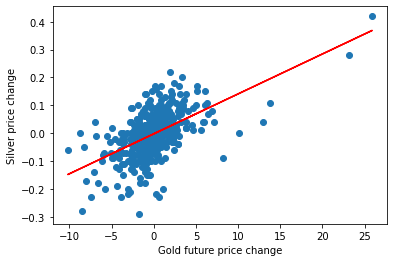

In [37]:
x, y = zip(*change_pairs)

gradient, offset = np.polyfit(x, y, 1)
regression = np.array(x) * gradient + offset

plt.scatter(x,y)
plt.plot(x, regression, color='red')
plt.xlabel('Gold future price change')
plt.ylabel('Silver price change')
plt.show()

In [53]:
test_gold_futures = futures_load('GC01G.csv')

# End of training period
training_end = gold_futures.index[-1]

# Hedging from training end 
init_future_price = test_gold_futures[training_end]
init_silver_price = spot_prices.loc[training_end]['Silver']

test_grad = spot_prices.loc[training_end]['Silver'] / spot_prices.loc[training_end]['Gold']

# Hedging 1000 ounces of silver
silver_ounces = 1000
hedging_contracts = gradient * silver_ounces#abs(silver_ounces / gradient)

daily_updates = []
for date in test_gold_futures[training_end:].index:
    distance = (date - training_end).days
    silver_change = silver_ounces * (spot_prices.loc[date]['Silver'] - init_silver_price)
    future_value = hedging_contracts * (test_gold_futures[training_end] - spot_prices.loc[date]['Gold'])
    daily_updates.append((distance, silver_change, future_value, silver_change + future_value))

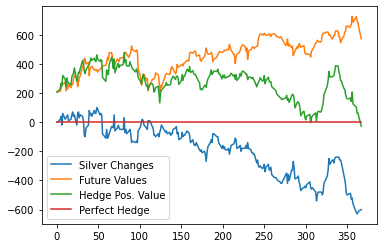

Loss on silver: -599.9999999999997
Loss with hedge: -27.92306344722897


In [65]:
day, silver_changes, future_values, hedge_position_values = zip(*daily_updates)

plt.plot(day, silver_changes, label='Silver Changes')
plt.plot(day, future_values, label='Future Values')
plt.plot(day, hedge_position_values, label='Hedge Pos. Value')
plt.plot(day, [0] * len(day), label='Perfect Hedge')
plt.legend()
plt.show()

print('Loss on silver:', silver_changes[-1])
print('Loss with hedge:', hedge_position_values[-1])